# **02. 탐색적 데이터 분석**

### **라이브러리 호출**

In [549]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import pyproj

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns

import ast
from datetime import datetime, date, timedelta
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [550]:
apartment = pd.read_csv("apartment_20230910.csv")

### **지리적 구분에 따른 데이터 탐색**

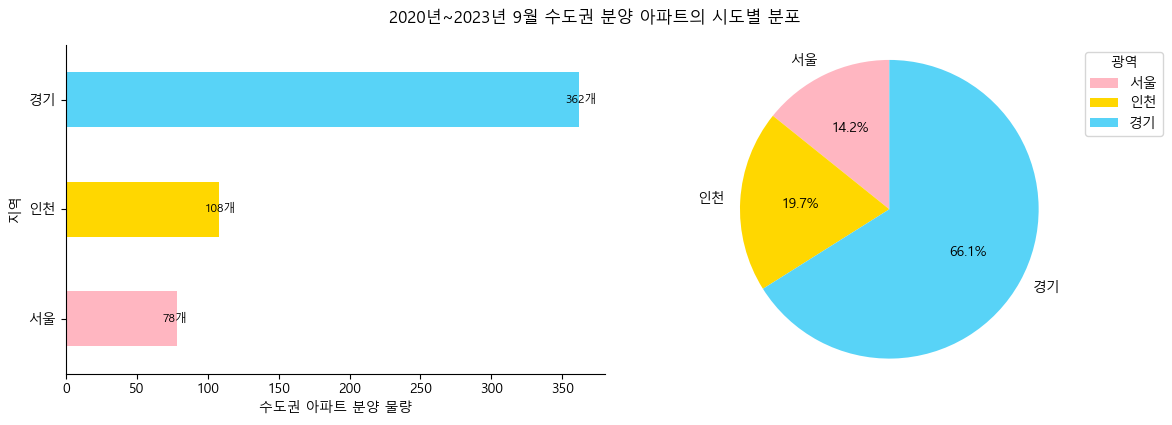

In [551]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#FFB6C1', '#FFD700', '#58D3F7']

area_data = apartment[['아파트명', '광역', '기초']]
metropolitan = area_data.drop_duplicates()['광역'].value_counts()
metropolitan = metropolitan.sort_values(ascending=True)

metropolitan.plot(kind='barh', ax=axs[0], color=colors)
axs[0].set_xlabel("수도권 아파트 분양 물량")
axs[0].set_ylabel("지역")
for i, v in enumerate(metropolitan.values):
    axs[0].text(v-10, i, str(v)+'개', va='center', fontsize=8.5, color='black')
    
axs[1].pie(metropolitan.values, labels=metropolitan.index, colors=colors, autopct='%1.1f%%', startangle=90)
axs[1].axis('equal')
axs[1].legend(metropolitan.index, title="광역", loc="upper left", bbox_to_anchor=(0.85, 1))

sns.despine()
plt.tight_layout()
plt.suptitle("2020년~2023년 9월 수도권 분양 아파트의 시도별 분포", y=1.05)
plt.show()

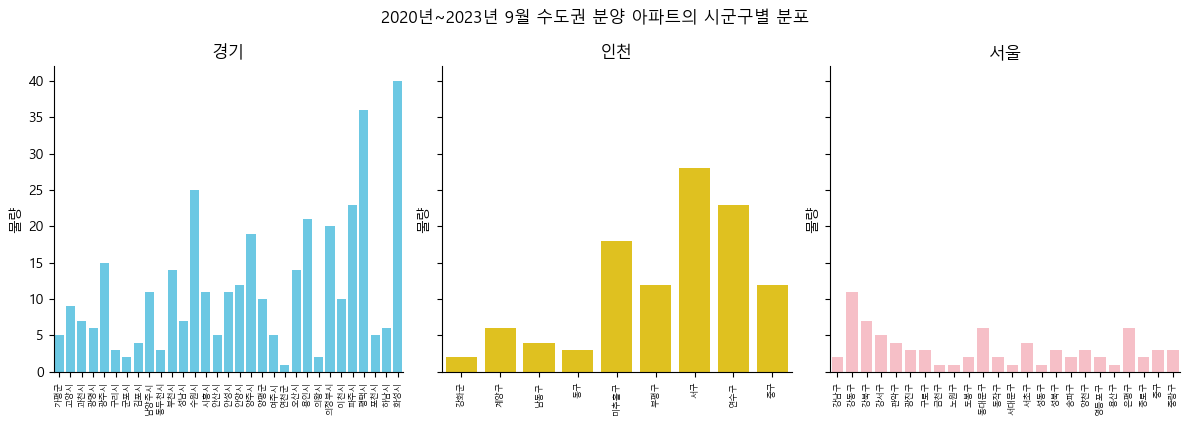

In [552]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

local_data = area_data.drop_duplicates().groupby(['광역', '기초']).count().reset_index().rename(columns={'아파트명': '물량'})

regions = ['경기', '인천', '서울']
color = ['#58D3F7', '#FFD700', '#FFB6C1']

for i, region in enumerate(regions):
    sns.barplot(data=local_data[local_data['광역']==region], x='기초', y='물량', ax=axs[i], color=color[i])
    axs[i].set_title(region)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), fontsize=6, rotation=90)
    axs[i].set_xlabel('')
    
sns.despine()
plt.tight_layout()
plt.suptitle("2020년~2023년 9월 수도권 분양 아파트의 시군구별 분포", y=1.05)
plt.show()

**대한민국 행정구역: http://www.gisdeveloper.co.kr/?p=2332**

In [553]:
# 시군구 데이터
korea_small_file = "C:/Users/henna/VSCODE/teamproject_apartment/sig.shp"
korea_small = gpd.read_file(korea_small_file, encoding='euc-kr')

# 시도데이터
korea_big_file = "C:/Users/henna/VSCODE/teamproject_apartment/ctprvn.shp"
korea_big = gpd.read_file(korea_big_file, encoding='euc-kr')

korea_small['시도'] = korea_small['SIG_CD'].apply(lambda x: x[0:2])
korea = pd.merge(korea_small, korea_big, left_on='시도', right_on='CTPRVN_CD', how='left')
korea.drop(['SIG_ENG_NM', 'CTPRVN_CD', 'CTP_ENG_NM', 'geometry_y'], axis=1, inplace=True)
korea.rename(columns={'geometry_x': 'geometry'}, inplace=True)

our_data = korea[korea['CTP_KOR_NM'].isin(['서울특별시', '인천광역시', '경기도'])]

In [554]:
apartment = apartment.copy()
map_data = apartment[['아파트명', '법정동주소', '위도', '경도']]
map_data = map_data.drop_duplicates()
map_data.head(3)

,아파트명,법정동주소,위도,경도
0,올림픽파크포레온,서울특별시 강동구 둔촌1동 170-1,37.522886,127.140539
16,디에이치퍼스티어아이파크,서울특별시 강남구 개포1동 660-4번지 일원,37.480769,127.057449
27,산성역자이푸르지오(성남),경기도 성남시 수정구 신흥동 1132,37.448634,127.147868


**데이터 간의 위경도 기준 맞추기**  
우리 데이터는 WGS 84 좌표 시스템(EPSG:4326) 기준인데 받은 데이터는 GRS80 / UTM-K 좌표 시스템(EPSG:5179)으로 변경 필요

In [555]:
source_crs = pyproj.CRS("EPSG:4326")
target_crs = pyproj.CRS("EPSG:5179")

transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

apartment_transformed = map_data.copy()

x, y = transformer.transform(map_data['경도'], map_data['위도'])
apartment_transformed['경도'] = x
apartment_transformed['위도'] = y
apartment_transformed['geometry'] = gpd.points_from_xy(apartment_transformed['경도'], apartment_transformed['위도'])
apartment_transformed_gdf = gpd.GeoDataFrame(apartment_transformed, 
                                              geometry=gpd.points_from_xy(apartment_transformed['경도'], apartment_transformed['위도']))

In [556]:
apartment_transformed_gdf.head(3)

,아파트명,법정동주소,위도,경도,geometry
0,올림픽파크포레온,서울특별시 강동구 둔촌1동 170-1,1.947126e+06,968236.860961,POINT (968236.861 1947126.036)
16,디에이치퍼스티어아이파크,서울특별시 강남구 개포1동 660-4번지 일원,1.942485e+06,960872.752796,POINT (960872.753 1942484.782)
27,산성역자이푸르지오(성남),경기도 성남시 수정구 신흥동 1132,1.938886e+06,968853.666618,POINT (968853.667 1938885.875)


**2020년 ~ 2023년 9월 분양 데이터 아파트의 지도상 분포**

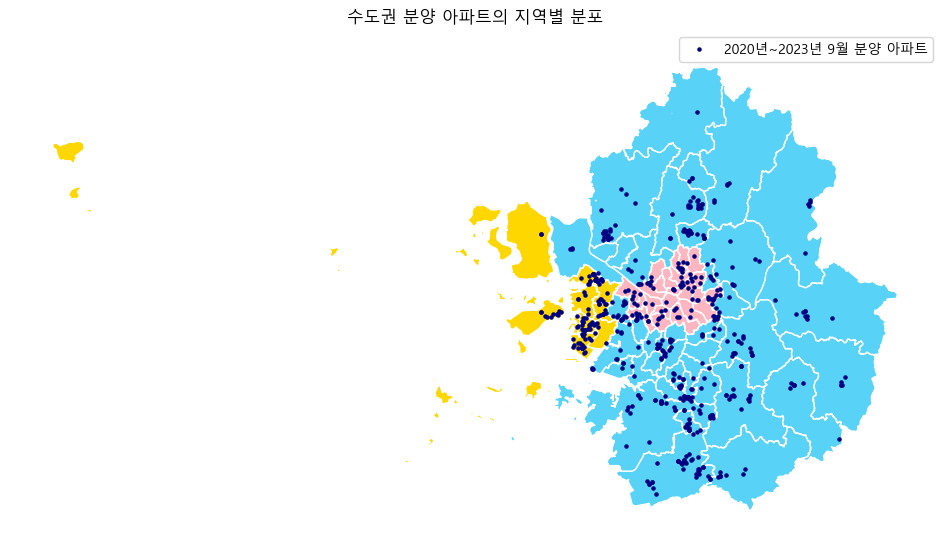

In [557]:
fig, ax = plt.subplots(figsize=(12, 9))

seoul = our_data[our_data['CTP_KOR_NM'] == '서울특별시'] 
gyeonggi = our_data[our_data['CTP_KOR_NM'] == '경기도'] 
incheon = our_data[our_data['CTP_KOR_NM'] == '인천광역시'] 

fig.patch.set_facecolor('none')

our_data.plot(color='lightgray', edgecolor='w', ax=ax)
seoul.plot(color='#FFB6C1', edgecolor='w', label='Seoul', ax=ax)
gyeonggi.plot(color='#58D3F7', edgecolor='w', label='Gyeonggi', ax=ax)
incheon.plot(color='#FFD700', edgecolor='w', label='Incheon', ax=ax)

apartment_transformed_gdf.plot(ax=ax, marker='o', color='navy', markersize=5, label='2020년~2023년 9월 분양 아파트')

plt.title("수도권 분양 아파트의 지역별 분포", y=1.0)
plt.axis('off')
plt.legend()
plt.show()

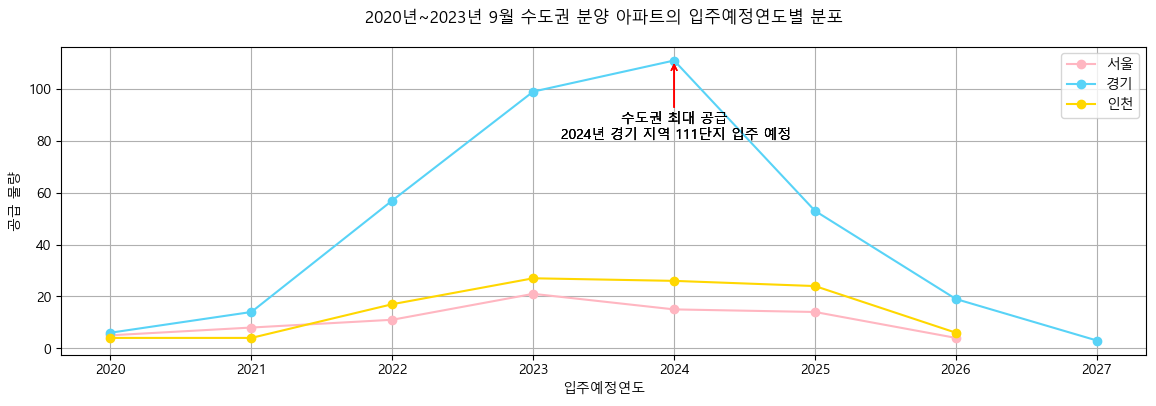

In [558]:
area_in_data = apartment[['아파트명', '광역', '입주예정연도']].drop_duplicates()
area_in_data = area_in_data.groupby(['광역', '입주예정연도']).count().reset_index().rename(columns={'아파트명': '물량'})


regions = ['서울', '경기', '인천']
color = ['#FFB6C1', '#58D3F7', '#FFD700']

max_row = area_in_data.loc[area_in_data['물량'].idxmax()]
max_gu = max_row['광역']
max_year = max_row['입주예정연도']

fig, ax = plt.subplots(figsize=(14, 4))

for idx, region in enumerate(regions):
    data = area_in_data[area_in_data['광역'] == region]
    ax.plot(data['입주예정연도'], data['물량'], marker='o', color=color[idx], label=region)
    ax.annotate(f'수도권 최대 공급\n {max_year}년 경기 지역 {max_row["물량"]}단지 입주 예정',
                xy=(max_year, max_row["물량"]), xytext=(max_year, max_row["물량"]-30),
                ha='center', arrowprops=dict(arrowstyle='->', color='red'))

ax.set_xlabel('입주예정연도')
ax.set_ylabel('공급 물량')
ax.set_title('2020년~2023년 9월 수도권 분양 아파트의 입주예정연도별 분포', y=1.05)

plt.legend()
plt.grid(True)
plt.show()


**시군구별 상권 현황 분석**

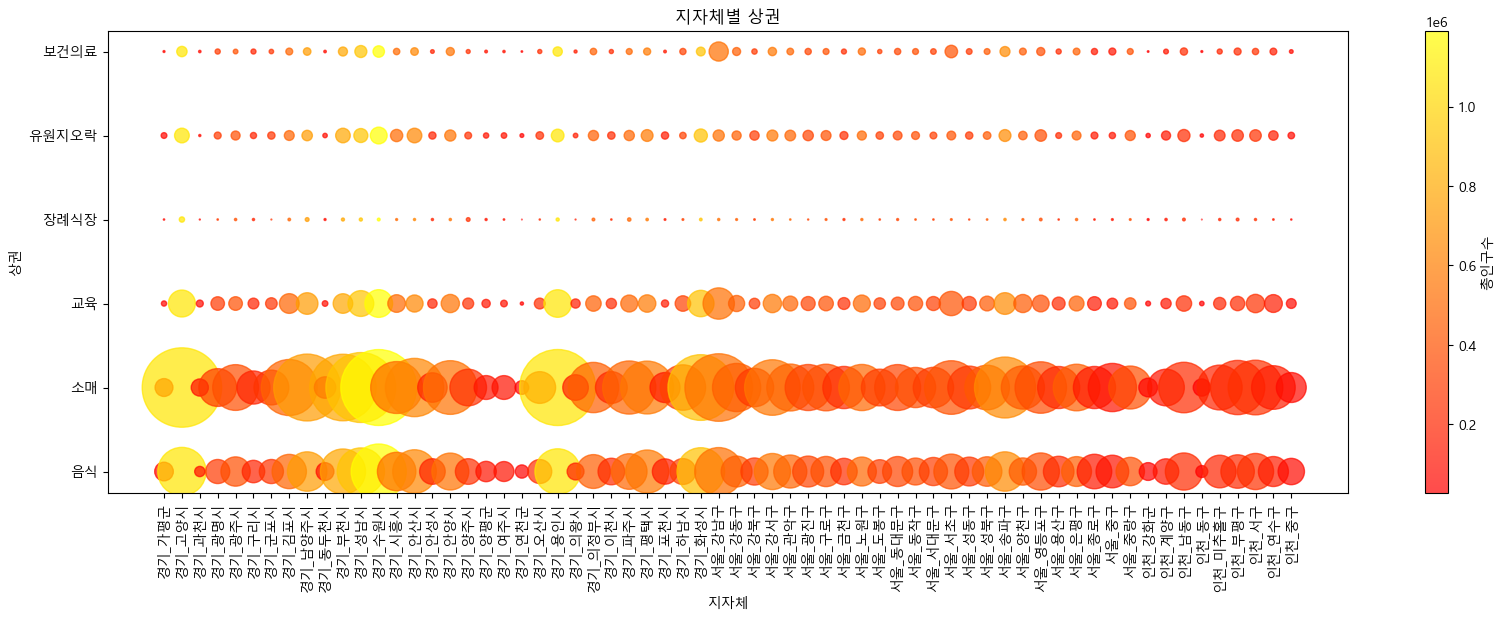

In [559]:
local_data = apartment[['광역', '기초', '소매', '음식', '교육', '장례식장', '보건의료', '유원지오락', '총인구수', '시군구내_통근통학', '타시군구_통근통학', '타시군구/시군구내']].drop_duplicates()
local_data['지역'] = local_data['광역'] + '_' + local_data['기초']
local_data.drop(['광역', '기초'], axis=1, inplace=True)
local_data.set_index('지역', inplace=True)
local_data.sort_index(inplace=True)


y_columns = ['음식', '소매', '교육', '장례식장', '유원지오락', '보건의료']
plt.figure(figsize=(20, 6))
x_values = local_data.index

for column in y_columns:
    sizes = local_data[column] / 10
    colors = local_data['총인구수']
    plt.scatter(x_values, [column] * len(x_values), s=sizes, c=colors, cmap='autumn', alpha=0.7)

plt.xlabel('지자체')
plt.ylabel('상권')
plt.colorbar(label='총인구수')

plt.title('지자체별 상권')
plt.xticks(rotation=90)
plt.show()


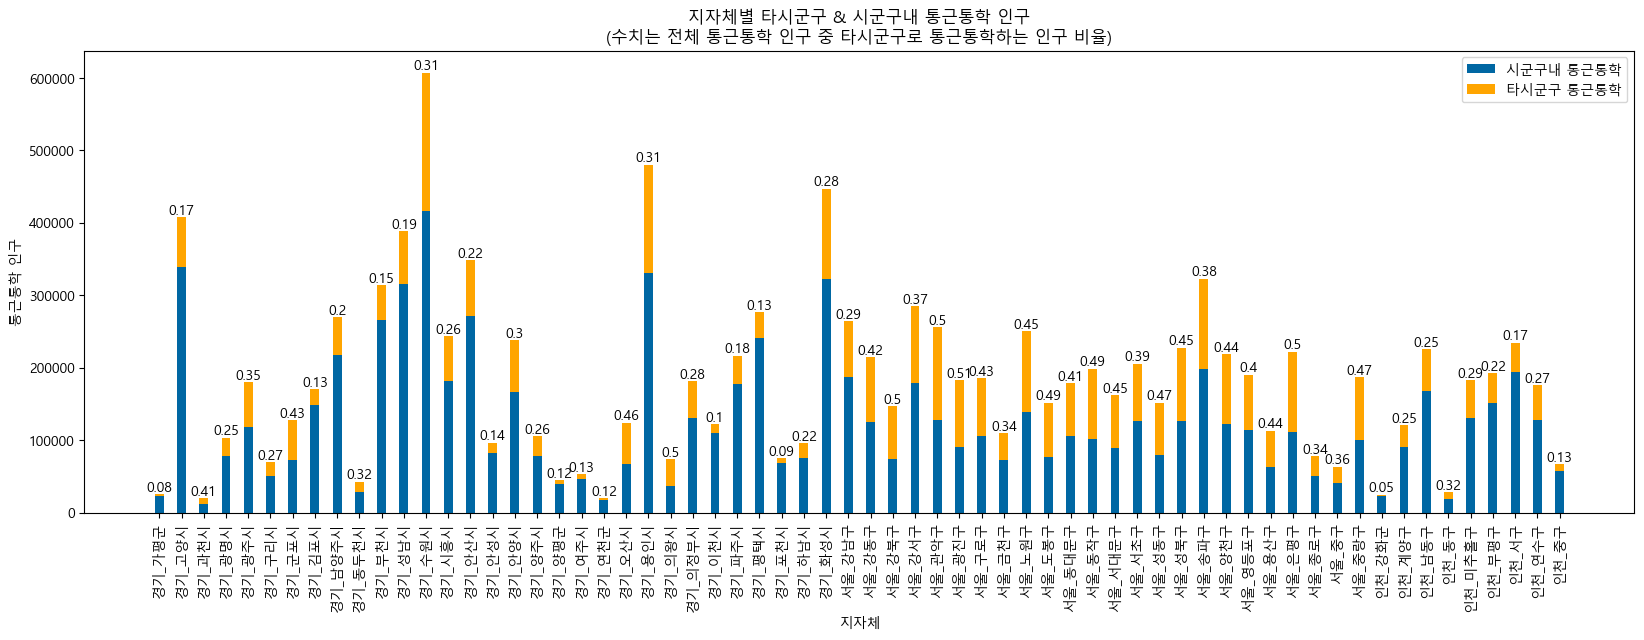

In [560]:
commute_data = local_data[['시군구내_통근통학', '타시군구_통근통학']]

plt.figure(figsize=(20, 6))

x_values = range(len(commute_data.index))

plt.bar(x_values, commute_data['시군구내_통근통학'], color='#0067A3', width=0.4, label='시군구내 통근통학')
plt.bar(x_values, commute_data['타시군구_통근통학'], color='#FFA500', width=0.4, label='타시군구 통근통학', bottom=commute_data['시군구내_통근통학'])

plt.xticks(x_values, commute_data.index, rotation=90)

for i, value in enumerate(commute_data['타시군구_통근통학'] / (commute_data['시군구내_통근통학']+commute_data['타시군구_통근통학'])):
    rounded_value = round(value, 2)
    plt.text(i, commute_data['시군구내_통근통학'][i] + commute_data['타시군구_통근통학'][i] + rounded_value, str(rounded_value), ha='center', va='bottom', fontsize=10)
    
plt.xlabel('지자체')
plt.ylabel('통근통학 인구')
plt.title('지자체별 타시군구 & 시군구내 통근통학 인구\n(수치는 전체 통근통학 인구 중 타시군구로 통근통학하는 인구 비율)')

plt.legend()
plt.show()


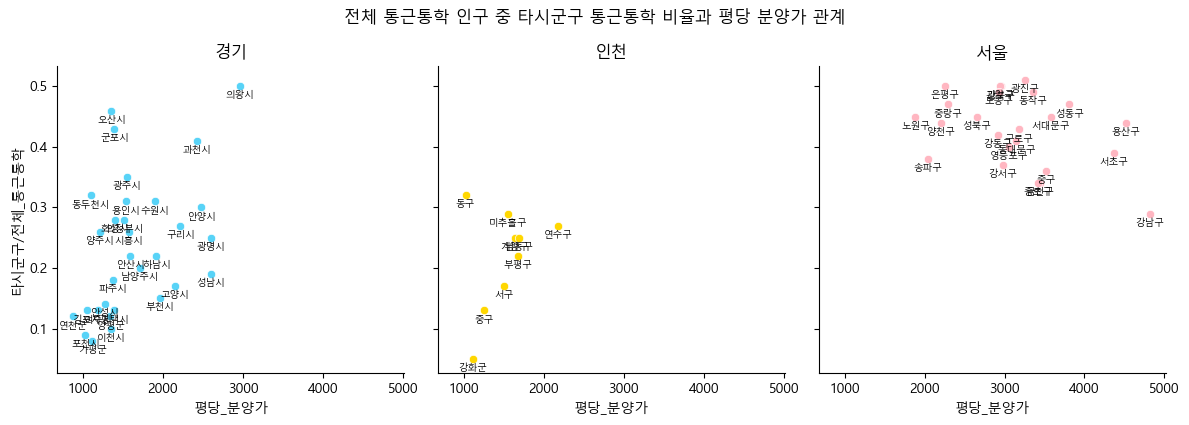

In [561]:
per_price = apartment[['아파트명', '평당_공급액']].groupby('아파트명').mean().reset_index()
mean_apartment = per_price.merge(apartment[['아파트명', '광역', '기초', '시군구내_통근통학', '타시군구_통근통학']], how='left', on='아파트명').drop_duplicates()
mean_apartment = mean_apartment.groupby(['광역', '기초', '시군구내_통근통학', '타시군구_통근통학'])['평당_공급액'].mean().reset_index()
mean_apartment['타시군구/전체_통근통학'] = round(mean_apartment['타시군구_통근통학'] / (mean_apartment['시군구내_통근통학']+mean_apartment['타시군구_통근통학']), 2)
mean_apartment.drop(['시군구내_통근통학', '타시군구_통근통학'], axis=1, inplace=True)


fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)

regions = ['경기', '인천', '서울']
colors = ['#58D3F7', '#FFD700', '#FFB6C1']

for i, region in enumerate(regions):
    data_region = mean_apartment[mean_apartment['광역'] == region]
    ax=sns.scatterplot(data_region, x='평당_공급액', y='타시군구/전체_통근통학', ax=axs[i], color=colors[i])    
    axs[i].set_title(region)
    axs[i].set_xlabel('평당_분양가')
        
    for small_row in range(0, data_region.shape[0]):
        x_val = data_region['평당_공급액'].iloc[small_row]
        y_val = data_region['타시군구/전체_통근통학'].iloc[small_row] - 0.02
        label = data_region['기초'].iloc[small_row]
        ax.text(x_val, y_val, label, horizontalalignment='center', size='x-small', color='black')
    
sns.despine()
plt.tight_layout()
plt.suptitle("전체 통근통학 인구 중 타시군구 통근통학 비율과 평당 분양가 관계", y=1.05)
plt.show()

### **개별 아파트에 따른 데이터 분포** 

**부동산 면적과 공급액과의 관계**

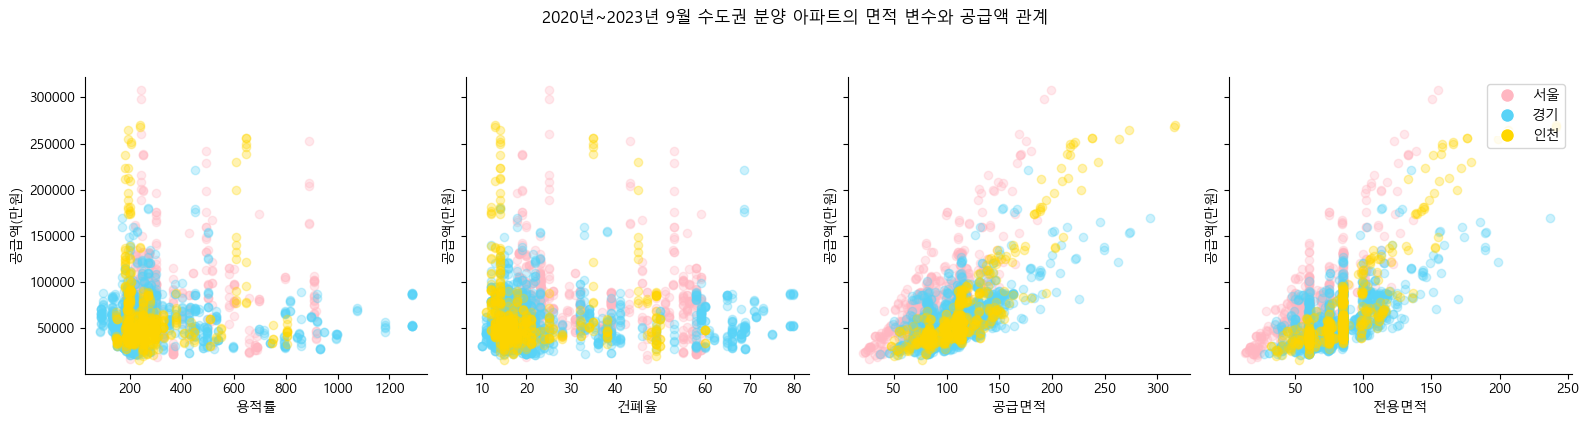

In [562]:
selected_data = apartment[['용적률', '건폐율', '공급면적', '전용면적', '공급액(만원)', '광역']]

colors = {'서울': '#FFB6C1',
          '경기': '#58D3F7',
          '인천': '#FFD700'}

columns = ['용적률', '건폐율', '공급면적', '전용면적']

fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, column in enumerate(columns):
    for region, color in colors.items():
        region_data = selected_data[selected_data['광역'] == region]
        scatter = axs[i].scatter(region_data[column], region_data['공급액(만원)'], alpha=0.3, label=region, c=color)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('공급액(만원)')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=region) for region, color in colors.items()]
plt.legend(handles=legend_labels, labels=colors.keys(), loc='upper right')

sns.despine()
plt.suptitle("2020년~2023년 9월 수도권 분양 아파트의 면적 변수와 공급액 관계", y=1.05)
plt.tight_layout()
plt.show()


**아파트 주변 환경과 공급액과의 관계**

In [563]:
env_apartment = per_price.merge(apartment[['아파트명', '지하철역', '노선명_리스트', '지하철역_거리']], how='left', on='아파트명').drop_duplicates()
env_apartment = env_apartment.reset_index(drop=True)
env_apartment['환승_노선'] = env_apartment['노선명_리스트'].apply(lambda x: len(ast.literal_eval(x)))

unique_routes = [route for sublist in env_apartment['노선명_리스트'] for route in ast.literal_eval(sublist)]
unique_routes = list(set(unique_routes))
for route in unique_routes:
    env_apartment[route] = env_apartment['노선명_리스트'].apply(lambda x: 1 if route in x else 0)

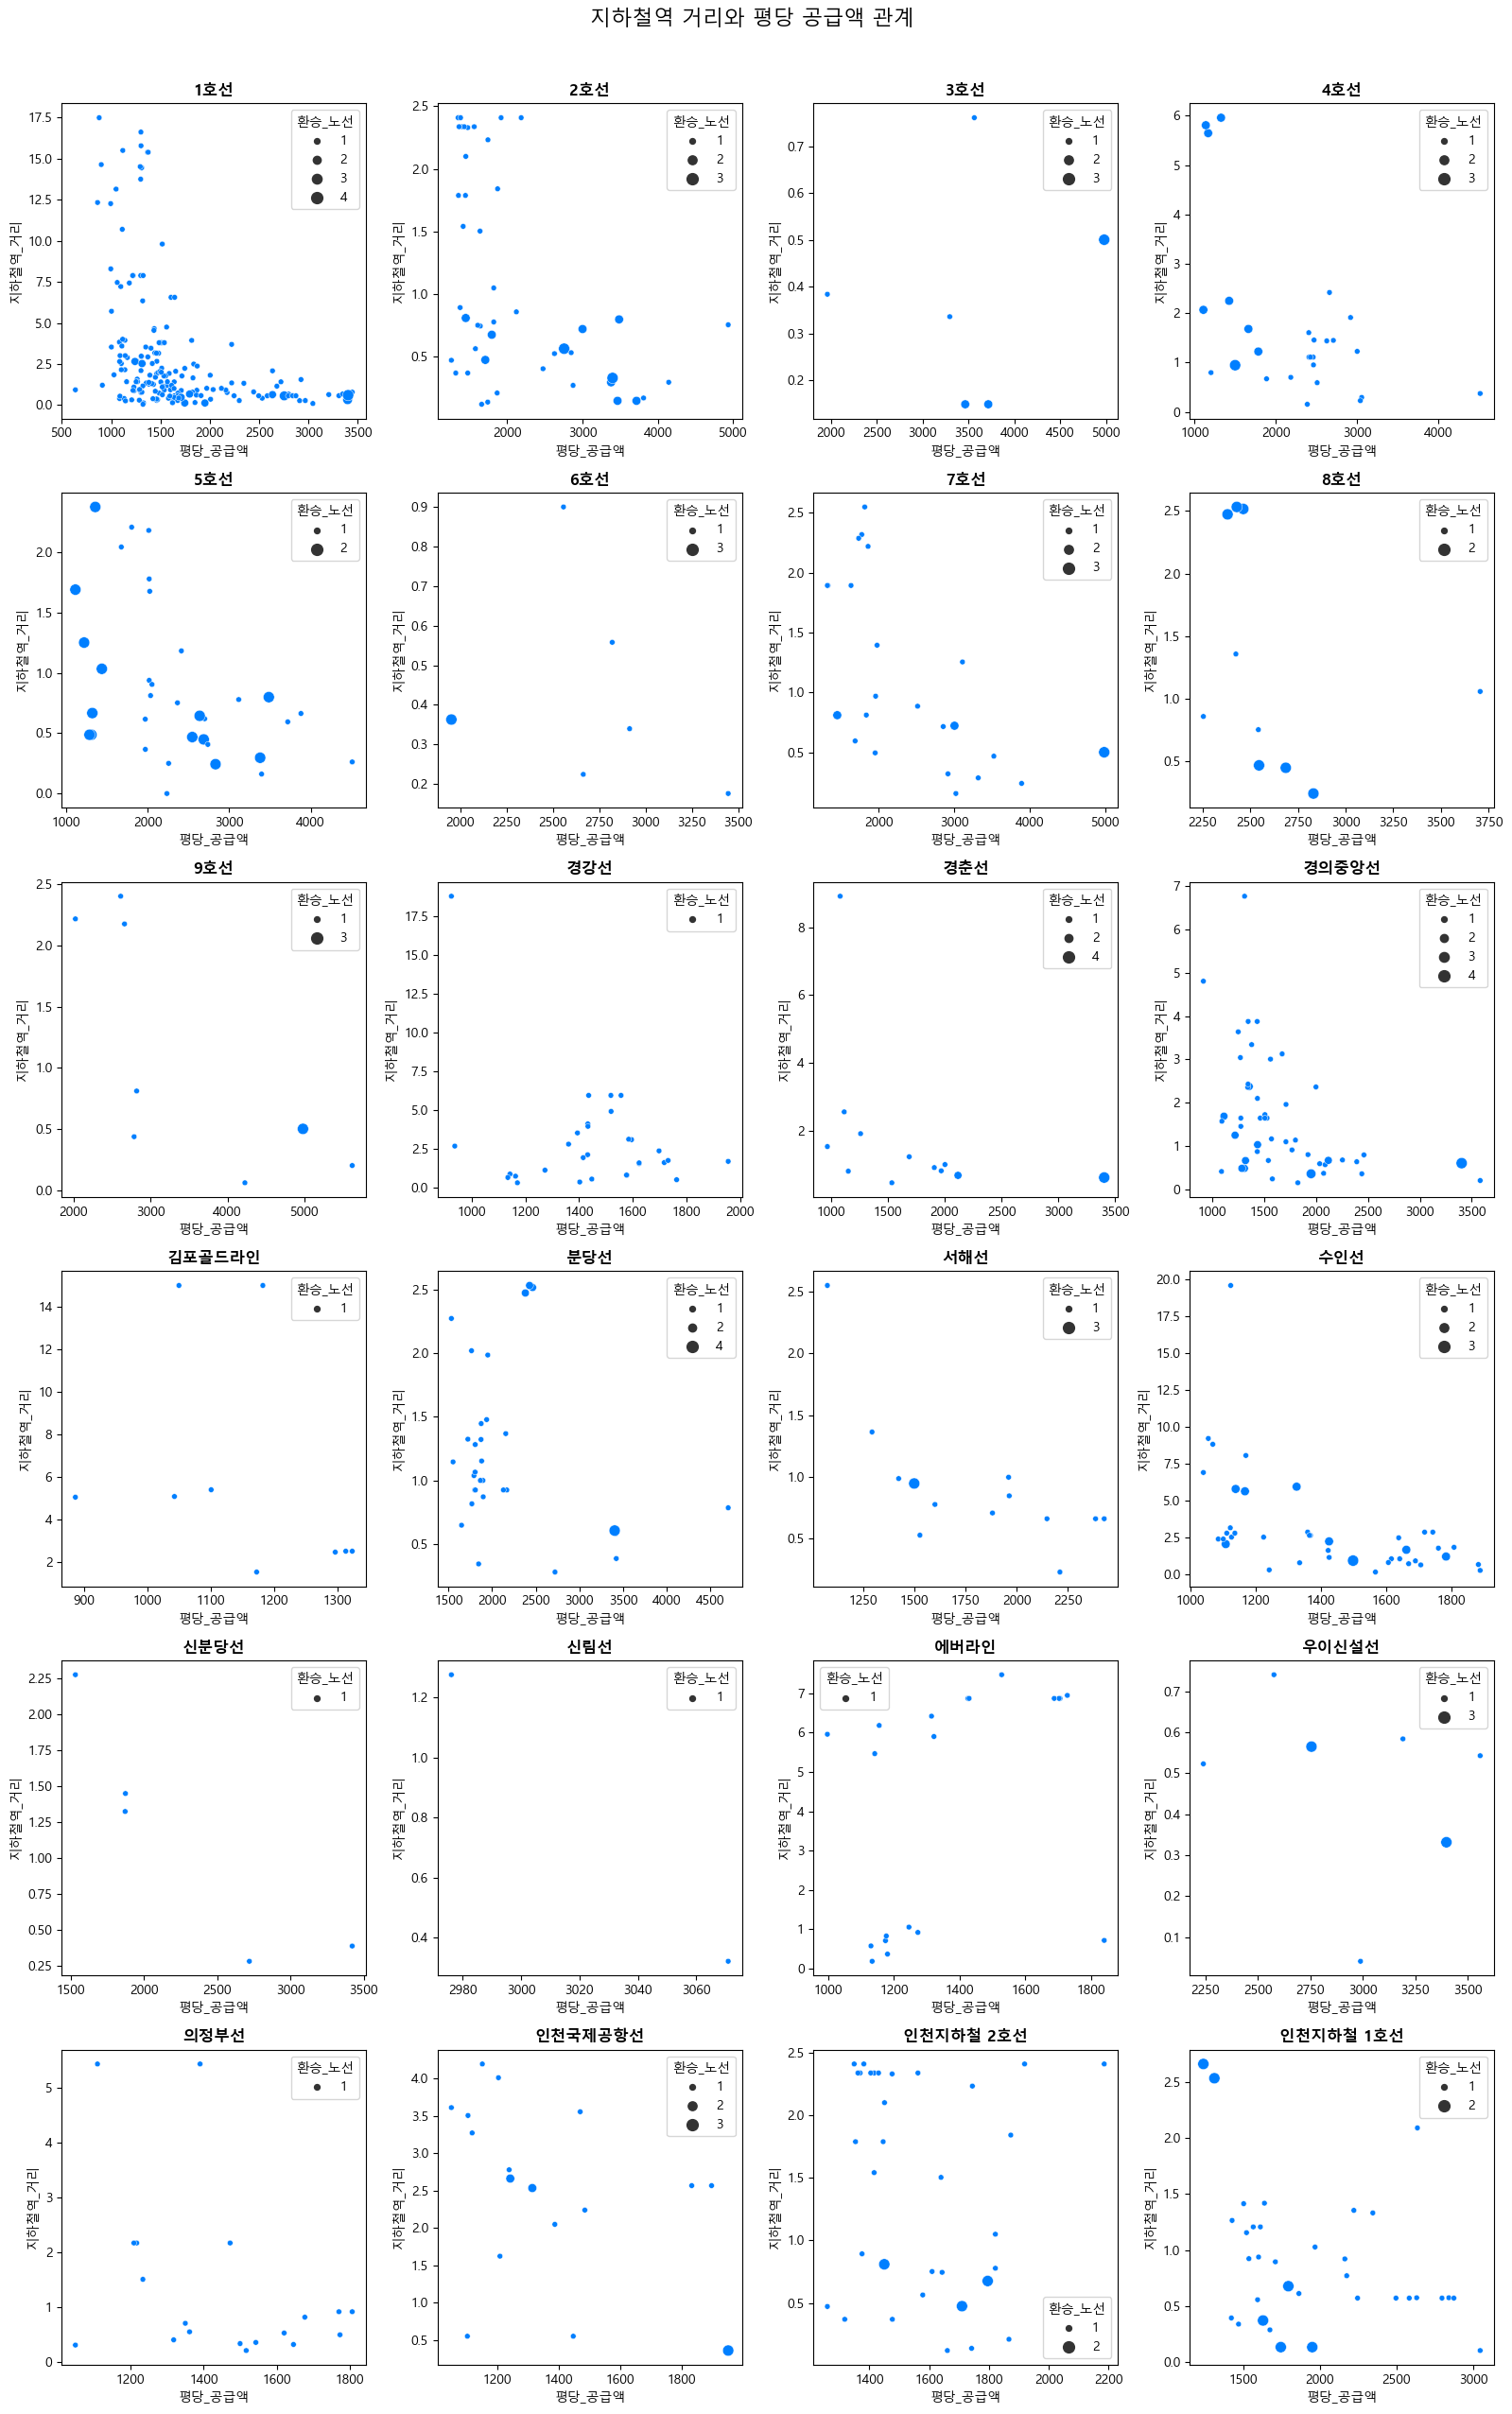

In [564]:
lines_data = env_apartment.drop(['노선명_리스트'], axis=1)
unique_routes = sorted(unique_routes, key=lambda x: x[0])

fig, axs = plt.subplots(figsize=(16, 26), nrows=6, ncols=4)

for i,feature in enumerate(unique_routes):
    row = int(i/4)
    col= i%4
    sns.scatterplot(data=lines_data[lines_data[feature]==1], x='평당_공급액', y='지하철역_거리', size=lines_data[lines_data[feature] == 1]['환승_노선'], color = "#007FFF", ax=axs[row][col])
    axs[row][col].set_title(feature, fontweight='bold')

plt.suptitle("지하철역 거리와 평당 공급액 관계", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

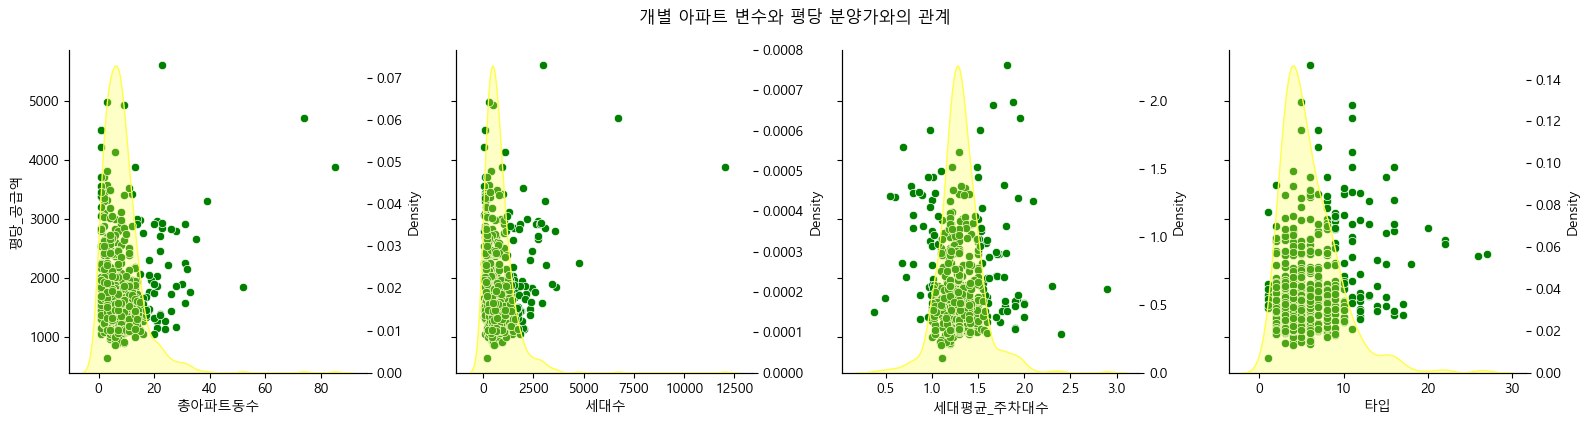

In [568]:
each = per_price.merge(apartment[['아파트명', '총아파트동수', '세대수', '세대평균_주차대수', '타입']], how='left', on='아파트명').drop_duplicates()
each = each.reset_index(drop=True)

fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

each_cols = ['총아파트동수', '세대수', '세대평균_주차대수', '타입']

for i, cols in enumerate(each_cols):
    ax = sns.scatterplot(data=each, x=cols, y='평당_공급액', ax=axs[i], color='#008000')
    axs[i].set_xlabel(cols)

    ax2 = axs[i].twinx()
    sns.kdeplot(data=each, x=cols, ax=ax2, color='#FEFD48', fill=True, alpha=0.3)

sns.despine()
plt.tight_layout()
plt.suptitle("개별 아파트 변수와 평당 분양가와의 관계", y=1.05)
plt.show()
